In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fmin_powell
from scipy import integrate

import theano as thno
import theano.tensor as T
import os


In [2]:
path_ = "/Users/rcuevas/Documents/Personal/ProLO-MeetUp/adultDataSet/"

In [18]:
df = pd.read_csv(path_+"adult.data.txt",header=None, names=['age', 'workclass', 'fnlwgt',
                'education-categorical', 'educ',
                'marital-status', 'occupation',
                'relationship', 'race', 'gender',
                'captial-gain', 'capital-loss',
                'hours', 'native-country',
                'income'])

In [20]:
df.head()

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,gender,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Handle missing values and recude study to Uniated States

In [21]:
df = df[~pd.isnull(df['income'])]

In [23]:
df = df[df['native-country']==" United-States"]

In [25]:
df['income'] = 1.*(df['income'] == " >50K")

In [27]:
df.income.value_counts()

0.0    21999
1.0     7171
Name: income, dtype: int64

Let's do some visualization

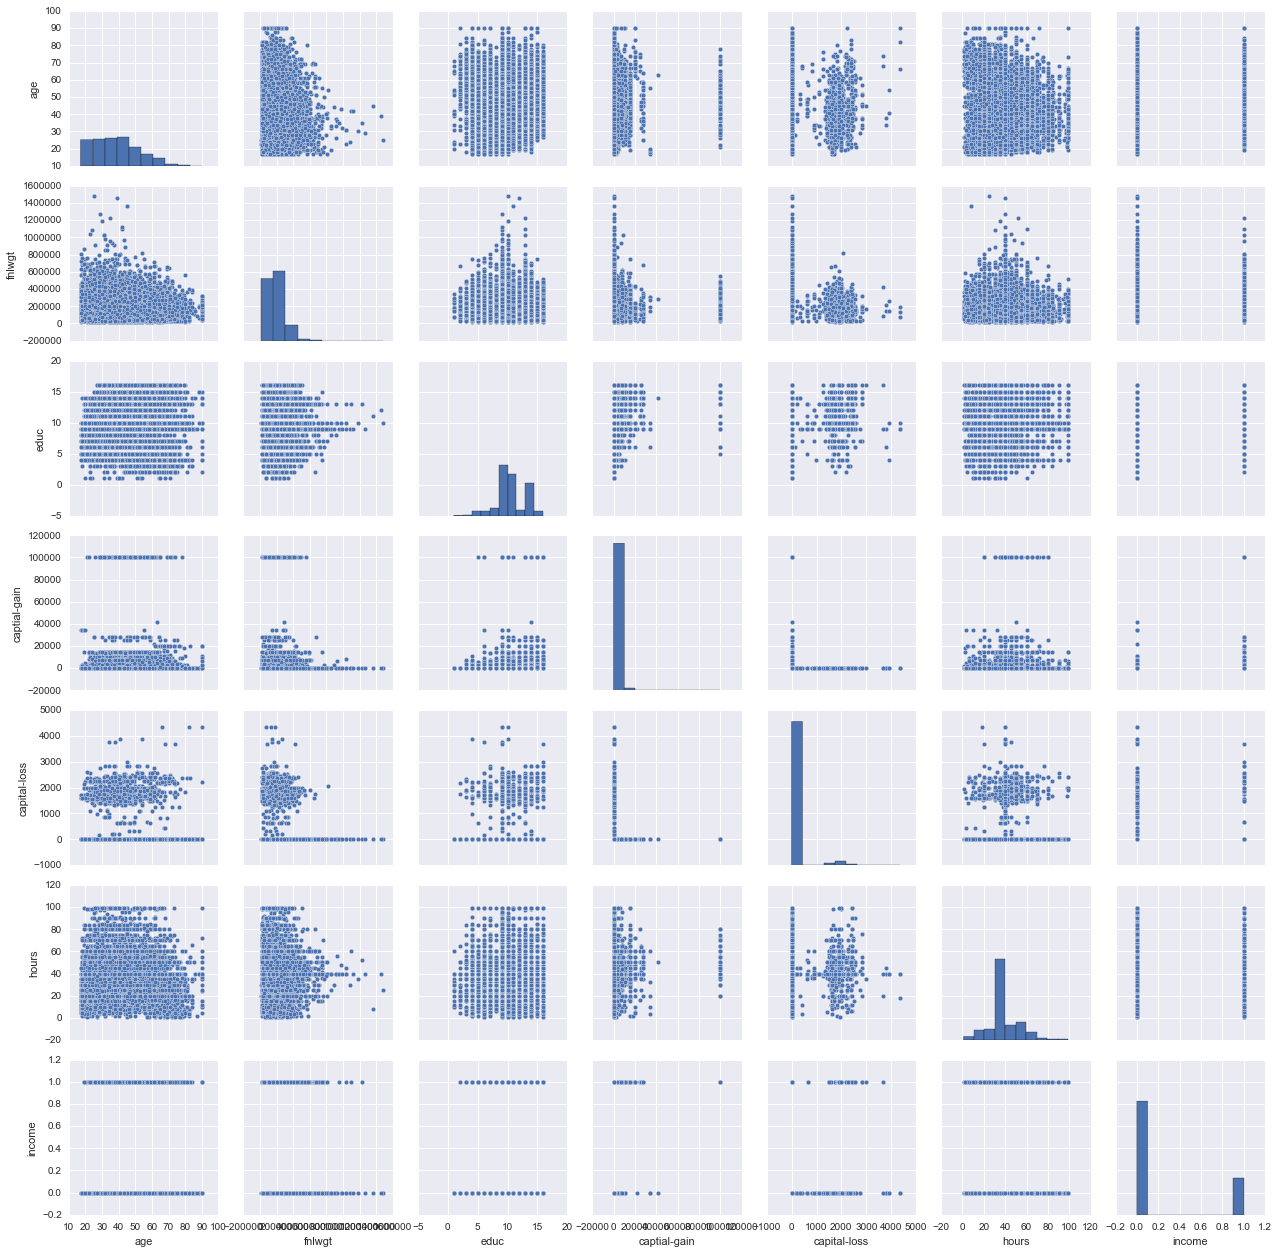

In [28]:
g = seaborn.pairplot(df)

Let's generate correlation matrix

In [33]:
# Compute correlation matrix
corrMatrix = df.corr()

In [34]:
corrMatrix

,age,fnlwgt,educ,captial-gain,capital-loss,hours,income
age,1.000000,-0.069518,0.033089,0.077409,0.057485,0.071453,0.234725
fnlwgt,-0.069518,1.000000,-0.012170,0.004182,-0.007882,-0.019809,0.001987
educ,0.033089,-0.012170,1.000000,0.127686,0.079305,0.161978,0.335994
captial-gain,0.077409,0.004182,0.127686,1.000000,-0.032194,0.078478,0.222601
capital-loss,0.057485,-0.007882,0.079305,-0.032194,1.000000,0.051498,0.149118
hours,0.071453,-0.019809,0.161978,0.078478,0.051498,1.000000,0.232551
income,0.234725,0.001987,0.335994,0.222601,0.149118,0.232551,1.000000


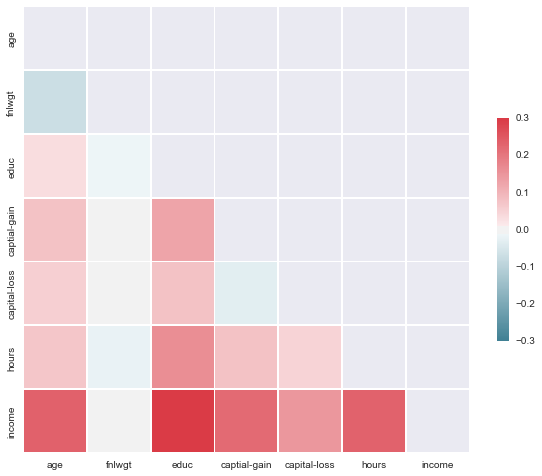

In [40]:

# Generate mask for upper triangle
mask = np.zeros_like(corrMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generatediverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw heatmap with mask and correct aspect ratio
seaborn.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=.3,
            linewidths=.8, cbar_kws={"shrink": .5}, ax=ax)

We will use a simple model, which assumes that the probability of making more than $50K is a function of age, years of education and hours worked per week. We will use PyMC3 do inference.

In Bayesian statistics, we treat everything as a random variable and we want to know the posterior probability distribution of the parameters (in this case the regression coefficients) The posterior is equal to the likelihood

$$
    \begin{equation}
    p(\theta|D) = \frac{p(D|\theta)p(\theta)}{p(D)}
    \end{equation}
$$

We now we need to specify a prior and a likelihood in order to draw samples from the posterior. Let’s use the default prior specification for the **Genearlized Linear Model (GLM)** (https://en.wikipedia.org/wiki/Generalized_linear_model#Intuition) coefficients that PyMC3 provides. That is $p(θ)=N(0,10^{12}I)$

In [43]:
with pm.Model() as logistic_model:
    pm.glm.glm('income ~ age + educ + hours', df, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(2000, pm.NUTS(), progressbar=True)


Applied logodds-transform to p and added transformed p_logodds_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 239.6 sec

We define the following function to the desired plots

In [47]:
def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')


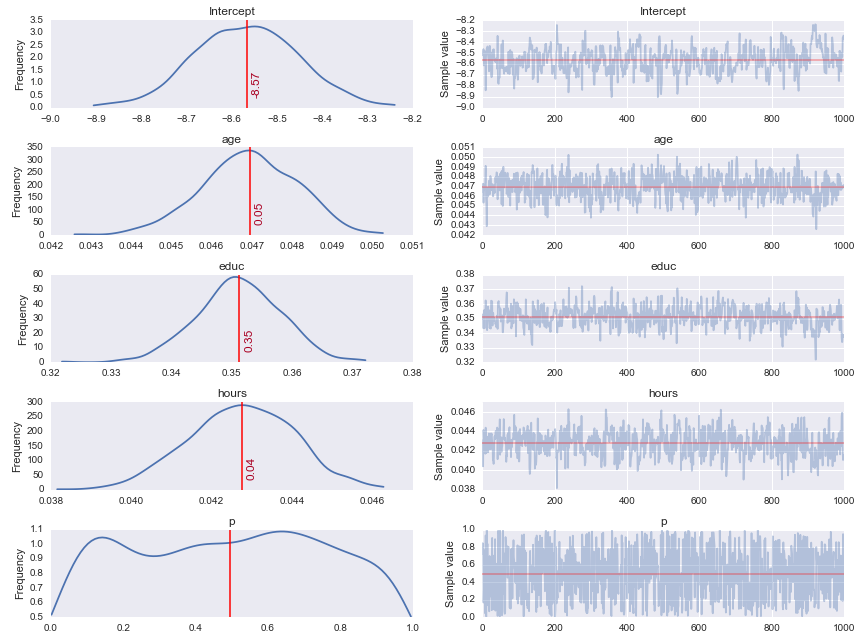

In [48]:
plot_traces(trace_logistic_model, retain=1000)

Bayesian inference returns a distribution over parameter values.

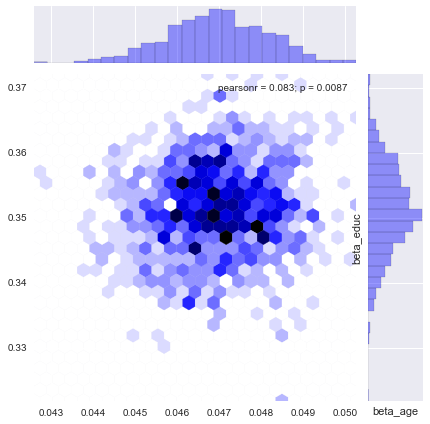

In [53]:
plt.figure(figsize=(9,7))
trace = trace_logistic_model[1000:]
seaborn.jointplot(trace['age'], trace['educ'], kind="hex", color="blue")
plt.xlabel("beta_age")
plt.ylabel("beta_educ")
plt.show()

Let's show how the probability of making more than $50K changes with age for a few different education levels. Here, we assume that the number of hours worked per week is fixed at 50. We need to give the function a linear model and a set of points to evaluate. We will pass in three different linear models: one with educ == 12 (finished high school), one with educ == 16 (finished undergrad) and one with educ == 19 (three years of grad school).

In [54]:
# Linear model with hours == 50 and educ == 12
lm1 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['age']*x +
                                          samples['educ']*12 +
                                          samples['hours']*50)))

# Linear model with hours == 50 and educ == 16
lm2 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['age']*x +
                                          samples['educ']*16 +
                                          samples['hours']*50)))

# Linear model with hours == 50 and educ == 19
lm3 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['age']*x +
                                          samples['educ']*19 +
                                          samples['hours']*50)))

In the followin, the red curve represents 19 years of education, the green curve represents 16 years of education and the blue curve represents 12 years of education. For all three education levels, the probability of making more than $50K increases with age until approximately age 60, when the probability begins to drop off

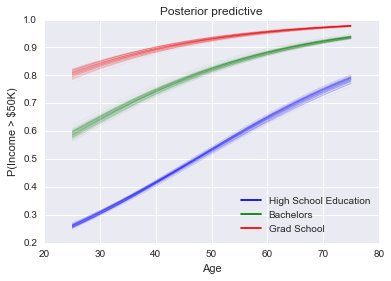

In [55]:
# Plot the posterior predictive distributions of P(income > $50K) vs. age
pm.glm.plot_posterior_predictive(trace, eval=np.linspace(25, 75, 1000), lm=lm1, samples=100, color="blue", alpha=.15)
pm.glm.plot_posterior_predictive(trace, eval=np.linspace(25, 75, 1000), lm=lm2, samples=100, color="green", alpha=.15)
pm.glm.plot_posterior_predictive(trace, eval=np.linspace(25, 75, 1000), lm=lm3, samples=100, color="red", alpha=.15)
import matplotlib.lines as mlines
blue_line = mlines.Line2D(['lm'], [], color='b', label='High School Education')
green_line = mlines.Line2D(['lm2'], [], color='g', label='Bachelors')
red_line = mlines.Line2D(['lm3'], [], color='r', label='Grad School')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show()

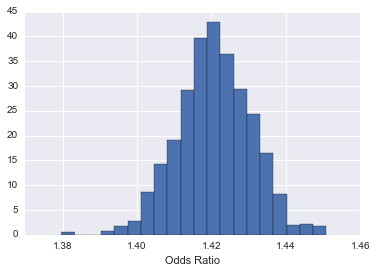

In [56]:
b = trace['educ']
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show()

We can find a credible interval (credible intervals are Bayesian and confidence intervals are frequentist) for this quantity. This may be the best part about Bayesian statistics: we get to interpret credibility intervals the way we’ve always wanted to interpret them. We are 95% confident that the odds ratio lies within our interval!

In [58]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)

print("P(%.3f < Odds Ratio < %.3f) = 0.95"%(np.exp(3*lb),np.exp(3*ub)))

P(2.752 < Odds Ratio < 2.986) = 0.95


The Deviance Information Criterion (DIC) is a method for comparing the deviance of likelhood across the the sample traces of a model run. However, this simplicity apparently yields quite good results in a variety of cases. We’ll run the model with a few changes to see what effect higher order terms have on this model. For this purpouse we define the following two functions:

In [59]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.glm(fml, df, family=pm.glm.families.Normal())

            start_MAP = pm.find_MAP(fmin=fmin_powell, disp=False)
            traces[nm] = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

    return models, traces


def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('income ~ educ + hours + age ' + ' '.join(['+ np.power(age,{})'.format(j)
                                     for j in range(2,k+1)])).strip()

Let's run polynomial models up to degree 4

In [61]:
models_lin, traces_lin = run_models(df, 4)


Running: k1
Applied log-transform to sd and added transformed sd_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 40.6 sec
Running: k2
Applied log-transform to sd and added transformed sd_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 79.7 sec
Running: k3
Applied log-transform to sd and added transformed sd_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 224.5 sec
Running: k4
Applied log-transform to sd and added transformed sd_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 971.7 sec

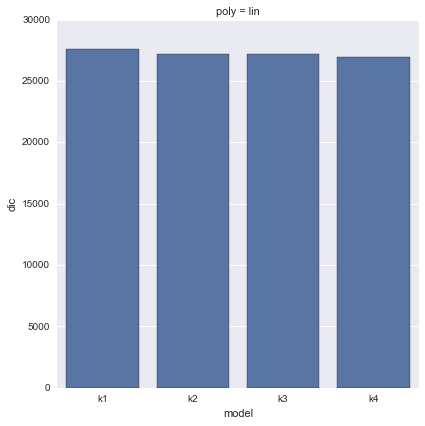

In [62]:
dfdic = pd.DataFrame(index=['k1','k2','k3','k4'], columns=['lin'])
dfdic.index.name = 'model'

for nm in dfdic.index:
    dfdic.loc[nm, 'lin'] = pm.stats.dic(traces_lin[nm],models_lin[nm])


dfdic = pd.melt(dfdic.reset_index(), id_vars=['model'], var_name='poly', value_name='dic')

g = seaborn.factorplot(x='model', y='dic', col='poly', hue='poly', data=dfdic, kind='bar', size=6)

Next we look at WAIC,  another model selection technique.

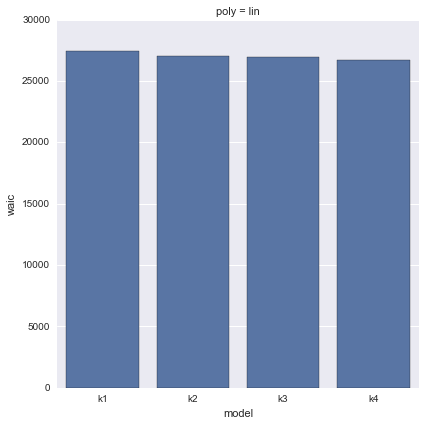

In [63]:
dfdic = pd.DataFrame(index=['k1','k2','k3','k4'], columns=['lin'])
dfdic.index.name = 'model'

for nm in dfdic.index:
    dfdic.loc[nm, 'lin'] = pm.stats.waic(traces_lin[nm],models_lin[nm])


dfdic = pd.melt(dfdic.reset_index(), id_vars=['model'], var_name='poly', value_name='waic')

g = seaborn.factorplot(x='model', y='waic', col='poly', hue='poly', data=dfdic, kind='bar', size=6)
